In [1]:
# imports
import os, sys

# third party imports
import numpy as np 
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

import voxelmorph as vxm
import neurite as ne
import pandas as pd

from tensorflow.keras.datasets import mnist

2025-01-07 15:10:34.730709: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
save_path = '/mnt/camca_NAS/4DCT/models/'

## Data

In [5]:
# load MNIST data. 
# `mnist.load_data()` already splits our data into train and test.  
(x_train_load, y_train_load), (x_test_load, y_test_load) = mnist.load_data()

digit_sel = 5

# extract only instances of the digit 5
x_train = x_train_load[y_train_load==digit_sel, ...]
y_train = y_train_load[y_train_load==digit_sel]
x_test = x_test_load[y_test_load==digit_sel, ...]
y_test = y_test_load[y_test_load==digit_sel]

# let's get some shapes to understand what we loaded.
print('shape of x_train: {}, y_train: {}'.format(x_train.shape, y_train.shape))

shape of x_train: (5421, 28, 28), y_train: (5421,)


In [6]:
nb_val = 1000  # keep 1,000 subjects for validation
x_val = x_train[-nb_val:, ...]  # this indexing means "the last nb_val entries" of the zeroth axis
y_val = y_train[-nb_val:]
x_train = x_train[:-nb_val, ...]
y_train = y_train[:-nb_val]

In [7]:
# fix data
x_train = x_train.astype('float')/255
x_val = x_val.astype('float')/255
x_test = x_test.astype('float')/255

# verify
print('training maximum value', x_train.max())

training maximum value 1.0


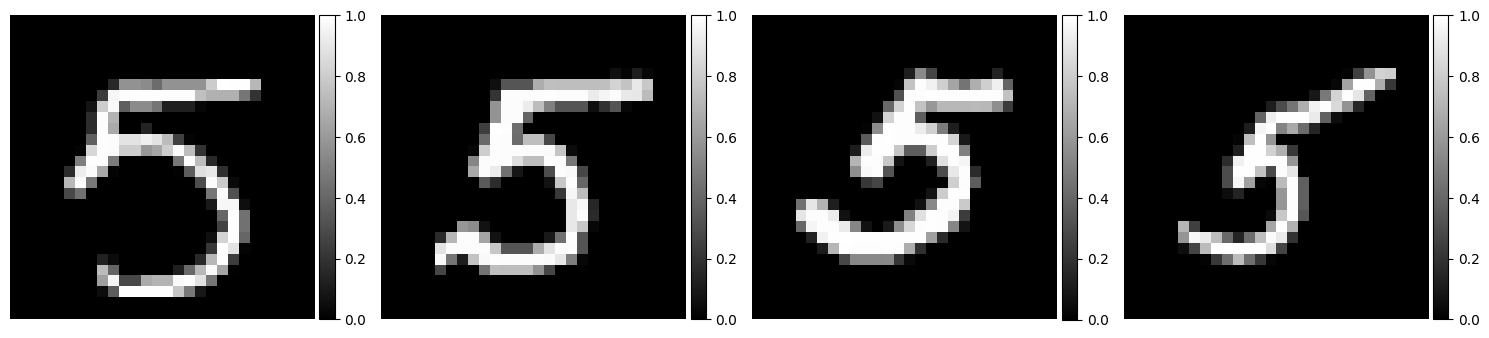

In [8]:
idx = np.random.choice(x_train.shape[0], 4, replace=False)
example_digits = [f for f in x_train[idx, ...]]
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

In [9]:
pad_amount = ((0, 0), (2,2), (2,2))

# fix data
x_train = np.pad(x_train, pad_amount, 'constant')
x_val = np.pad(x_val, pad_amount, 'constant')
x_test = np.pad(x_test, pad_amount, 'constant')

# verify
print('shape of training data', x_train.shape)

shape of training data (4421, 32, 32)


# CNN model

In [10]:
# configure unet input shape (concatenation of moving and fixed images)
ndim = 2
unet_input_features = 2
inshape = (*x_train.shape[1:], unet_input_features)

# configure unet features 
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

# build model
unet = vxm.networks.Unet(inshape=inshape, nb_features=nb_features)
print('input shape: ', unet.input.shape)
print('output shape:', unet.output.shape)

# transform the results into a flow field.
disp_tensor = tf.keras.layers.Conv2D(ndim, kernel_size=3, padding='same', name='disp')(unet.output)

# check tensor shape
print('displacement tensor:', disp_tensor.shape)

# using keras, we can easily form new models via tensor pointers
def_model = tf.keras.models.Model(unet.inputs, disp_tensor)

2024-12-16 19:46:02.545846: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-12-16 19:46:02.546466: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-12-16 19:46:02.566793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-16 19:46:02.568939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:13:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.50GiB deviceMemoryBandwidth: 1.41TiB/s
2024-12-16 19:46:02.568956: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-12-16 19:46:02.570681: I tensorflow/stream_executor/platform/defau

input shape:  (None, 32, 32, 2)
output shape: (None, 32, 32, 16)
displacement tensor: (None, 32, 32, 2)


## Loss

In [11]:
# build transformer layer
spatial_transformer = vxm.layers.SpatialTransformer(name='transformer')

# extract the first frame (i.e. the "moving" image) from unet input tensor
moving_image = tf.expand_dims(unet.input[..., 0], axis=-1)

# warp the moving image with the transformer
moved_image_tensor = spatial_transformer([moving_image, disp_tensor])

outputs = [moved_image_tensor, disp_tensor]
vxm_model = tf.keras.models.Model(inputs=unet.inputs, outputs=outputs)

## Rebuild using pre-defined model codes

In [12]:
# build model using VxmDense
inshape = x_train.shape[1:]
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))
# The `int_steps=0` option disables diffeomorphism, which will be covered in a more advanced tutorial.
# It's worth noting that the `VxmDense` model is automatically configured with two input tensors (moving and fixed inputs) instead of one. The input shape parameter should not contain any feature information, which can be set via the optional `src_feats` and `trg_feats` parameters.

input shape:  (None, 32, 32, 1), (None, 32, 32, 1)
output shape: (None, 32, 32, 1), (None, 32, 32, 2)


In [13]:
# Now that've learned how to easily build our networks, let's define the actual loss. The way keras works, we need to define a loss for each output.
# The first loss is easy, it's simply MSE between the warped image 𝑚∘𝜙. For the second, we will use a spatial gradient of the displacement.
# We won't code this from scratch here, but we'll use the voxelmorph implementation.

# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

vxm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=losses, loss_weights=loss_weights)

## Train model

In [18]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

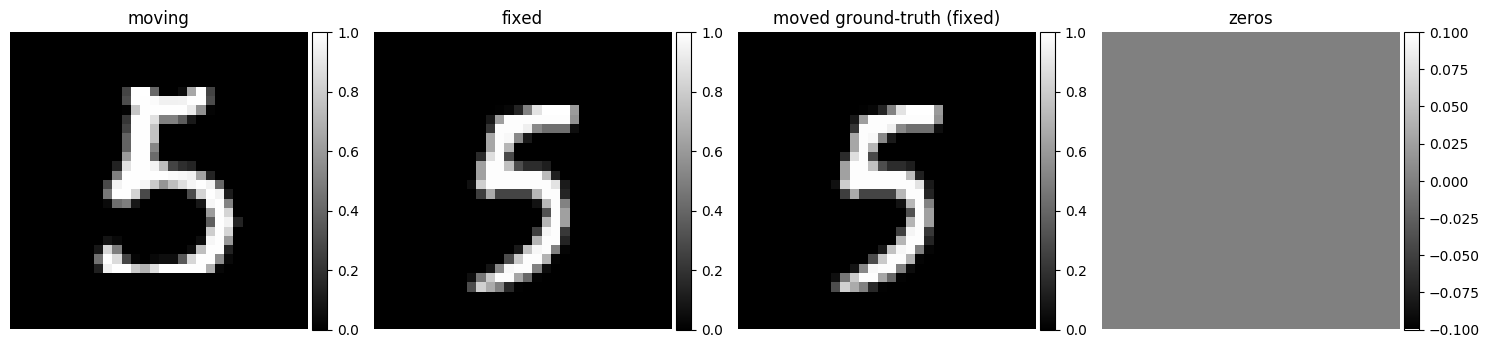

(<Figure size 1500x375 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f286b25fca0>,
       dtype=object))

In [34]:
# let's test it
batch_size = 32
train_generator = vxm_data_generator(x_train,batch_size = batch_size)
in_sample, out_sample = next(train_generator)

val_generator = vxm_data_generator(x_val, batch_size=batch_size)
in_sample_val, out_sample_val = next(val_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample_val + out_sample_val] 
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True)

In [41]:
# nb_epochs = 40
# steps_per_epoch = 100
# hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2)

training_steps = x_train.shape[0] // batch_size  # Number of steps for training per epoch
validation_steps =  x_val.shape[0] // batch_size # Number of steps for validation per epoch
validation_every_epoch = 1  # Validate every N epochs

nb_epochs = 300

# Initialize an Excel sheet data storage
excel_results = []

# Training loop
for epoch in range(nb_epochs):
    print(f"Epoch {epoch + 1}/{nb_epochs}")

    # Train the model for one epoch
    hist = vxm_model.fit(
        train_generator,
        steps_per_epoch= training_steps,
        epochs=1,
        verbose=1
    )

    # Get the training loss
    training_loss = hist.history['loss'][0]
    transformer_loss = hist.history.get('vxm_dense_transformer_loss', [None])[0]
    flow_loss = hist.history.get('vxm_dense_flow_loss', [None])[0]


    # Calculate validation loss every N epochs
    if epoch % validation_every_epoch == 0:
        val_hist = vxm_model.evaluate(val_generator, steps=validation_steps, verbose=1, return_dict=True)
        val_loss = val_hist['loss']
        val_transformer_loss = val_hist.get('vxm_dense_transformer_loss', None)
        val_flow_loss = val_hist.get('vxm_dense_flow_loss', None)
    
        epoch_results = [epoch + 1, training_loss, transformer_loss, flow_loss, val_loss, val_transformer_loss, val_flow_loss]
        print('epoch results:', epoch_results)
        excel_results.append(epoch_results)
        df = pd.DataFrame(excel_results, columns=['Epoch', 'Training Loss', 'Transformer Loss', 'Flow Loss', 'Validation Loss', 'Validation Transformer Loss', 'Validation Flow Loss'])
        file_name = os.path.join(save_path, 'training_metrics.xlsx')
        df.to_excel(file_name, index=False)

        # Save the model parameters for each epoch
        vxm_model.save(os.path.join(save_path,'vxm_model_epoch'+str(epoch + 1)+'.h5'))
        print(f"Model saved as 'vxm_model_epoch_{epoch + 1}.h5'")



Epoch 1/300
31/31 [==============================] - 1s 19ms/step - loss: 0.0088 - vxm_dense_transformer_loss: 0.0051 - vxm_dense_flow_loss: 0.0745
epoch results: [1, 0.008140373043715954, 0.004426013212651014, 0.07428716123104095, 0.008827870711684227, 0.0051038991659879684, 0.07447942346334457]
Model saved as 'vxm_model_epoch_1.h5'
Epoch 2/300
31/31 [==============================] - 1s 19ms/step - loss: 0.0083 - vxm_dense_transformer_loss: 0.0046 - vxm_dense_flow_loss: 0.0732
epoch results: [2, 0.008053810335695744, 0.0043575395829975605, 0.07392542064189911, 0.008288082666695118, 0.0046281334944069386, 0.07319900393486023]
Model saved as 'vxm_model_epoch_2.h5'
Epoch 3/300
31/31 [==============================] - 1s 19ms/step - loss: 0.0086 - vxm_dense_transformer_loss: 0.0049 - vxm_dense_flow_loss: 0.0728
epoch results: [3, 0.008118695579469204, 0.004378051031380892, 0.07481291890144348, 0.008556905202567577, 0.004919368773698807, 0.07275073230266571]
Model saved as 'vxm_model_epoc

: 

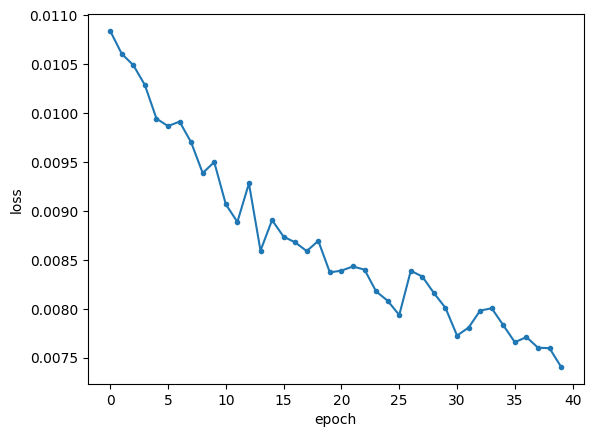

In [42]:
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(hist)

## Registration

In [43]:
# let's get some data
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)

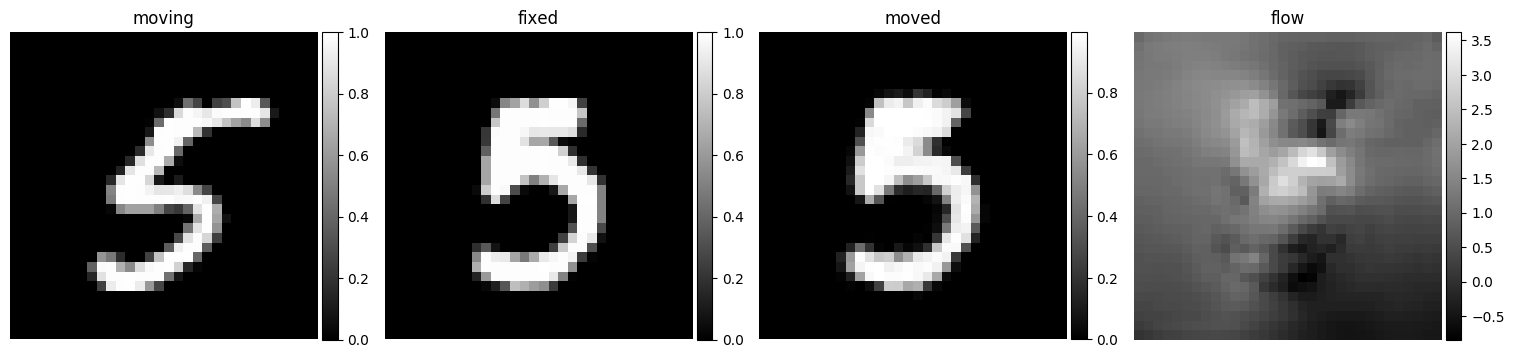

(<Figure size 1500x375 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e80c28160>,
       dtype=object))

In [44]:
val_pred = vxm_model.predict(val_input)
# visualize
# images = [img[0, :, :, 0] for img in val_input + val_pred] 
images = [val_input[0][0,:,:,0], val_input[1][0,:,:,0], val_pred[0][0,:,:,0], val_pred[1][0,:,:,0]]
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True)

## Brain MRI registration

In [14]:
# download MRI tutorial data
!wget https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz -O data.tar.gz
!tar -xzvf data.tar.gz

--2024-12-16 19:46:14--  https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.1.43
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.1.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16644702 (16M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]  15.87M  63.7MB/s    in 0.2s    

2024-12-16 19:46:15 (63.7 MB/s) - ‘data.tar.gz’ saved [16644702/16644702]

brain_2d_no_smooth.h5
brain_2d_smooth.h5
brain_3d.h5
fs_rgb.npy
subj1.npz
subj2.npz
tutorial_data.npz


train shape: (208, 192, 160)


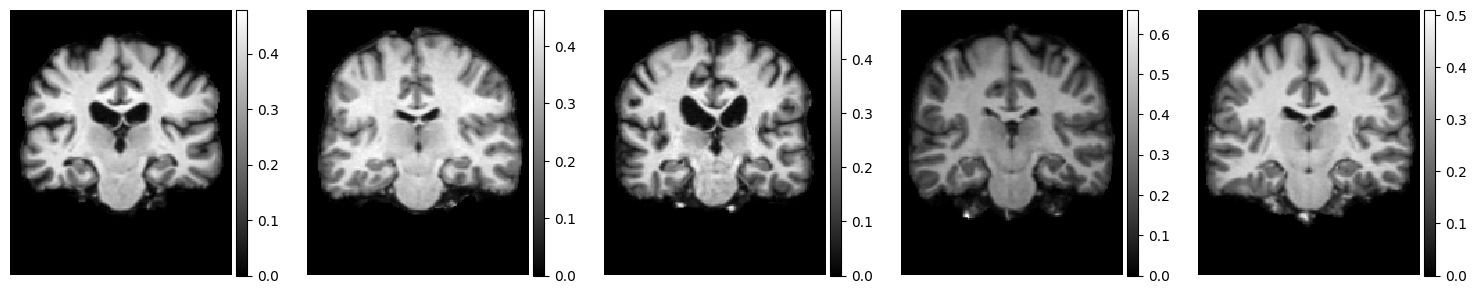

In [19]:
npz = np.load('tutorial_data.npz')
x_train = npz['train']
x_val = npz['validate']

# the 208 volumes are of size 160x192
vol_shape = x_train.shape[1:]
print('train shape:', x_train.shape)

# extract some brains
nb_vis = 5
idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

In [20]:
# unet
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)

# losses and loss weights
losses = ['mse', vxm.losses.Grad('l2').loss]
loss_weights = [1, 0.01]
vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)

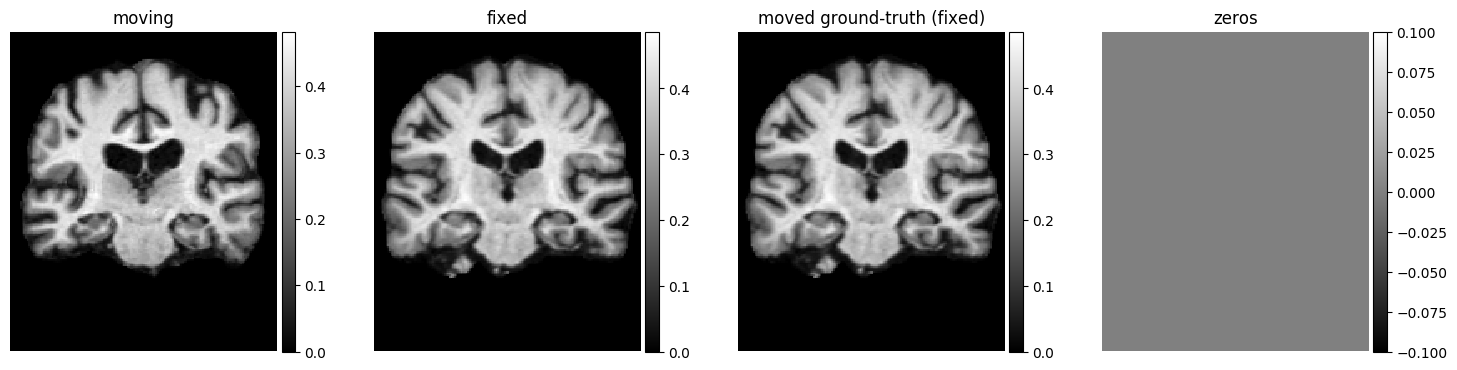

In [21]:
# let's test it
train_generator = vxm_data_generator(x_train, batch_size=8)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [22]:
# hist = vxm_model.fit_generator(train_generator, epochs=5, steps_per_epoch=5, verbose=2);
vxm_model.load_weights('brain_2d_smooth.h5') 

2024-12-16 19:46:43.819347: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-12-16 19:46:43.819708: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2245780000 Hz
2024-12-16 19:46:44.069002: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2024-12-16 19:46:45.819271: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-12-16 19:46:46.275876: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


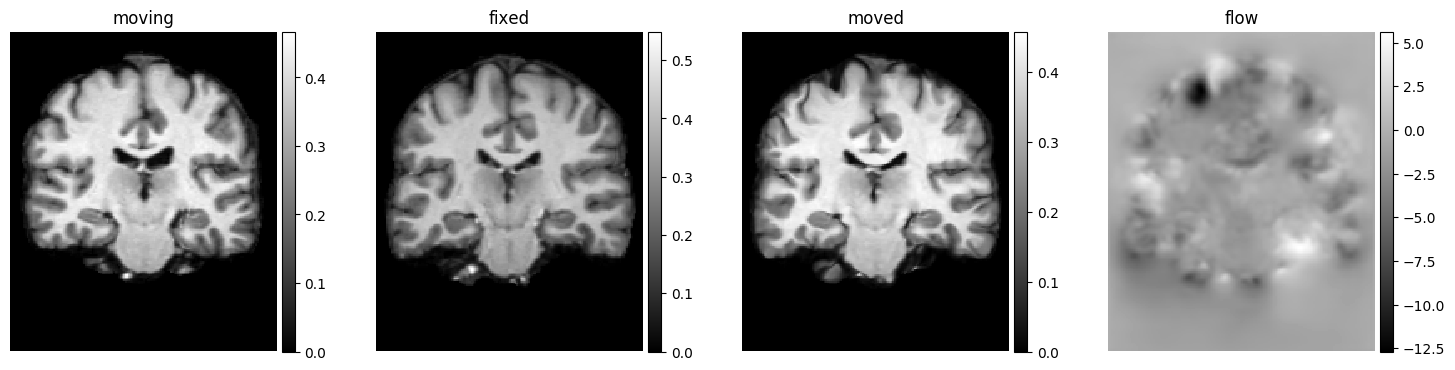

In [23]:
# create the validation data generator
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)
# prediction
val_pred = vxm_model.predict(val_input)
# visualize registration
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [24]:
val_pred[1].squeeze().shape

(192, 160, 2)

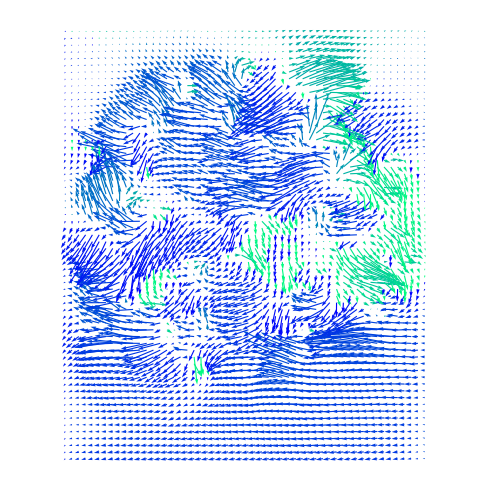

In [52]:
# visualize flow
flow = val_pred[1].squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

## 3D MRI brain registration

In [3]:
# our data will be of shape 160 x 192 x 224
vol_shape = (160, 192, 224)
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]
# build vxm network
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

2025-01-07 15:10:40.805693: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-01-07 15:10:40.806260: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-01-07 15:10:40.829103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-07 15:10:40.831240: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:13:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.50GiB deviceMemoryBandwidth: 1.41TiB/s
2025-01-07 15:10:40.831258: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2025-01-07 15:10:40.833176: I tensorflow/stream_executor/platform/defau

In [4]:
val_volume_1 = np.load('subj1.npz')['vol']
seg_volume_1 = np.load('subj1.npz')['seg']
val_volume_2 = np.load('subj2.npz')['vol']
seg_volume_2 = np.load('subj2.npz')['seg']

val_input = [
    val_volume_1[np.newaxis, ..., np.newaxis],
    val_volume_2[np.newaxis, ..., np.newaxis]
]

a = val_volume_1[np.newaxis, ..., np.newaxis]
print(a.shape)


(1, 160, 192, 224, 1)


In [58]:
vxm_model.load_weights('brain_3d.h5')

In [59]:
val_pred = vxm_model.predict(val_input)
moved_pred = val_pred[0].squeeze()
pred_warp = val_pred[1]

In [61]:
print(moved_pred.shape, pred_warp.shape)

(160, 192, 224) (1, 160, 192, 224, 3)


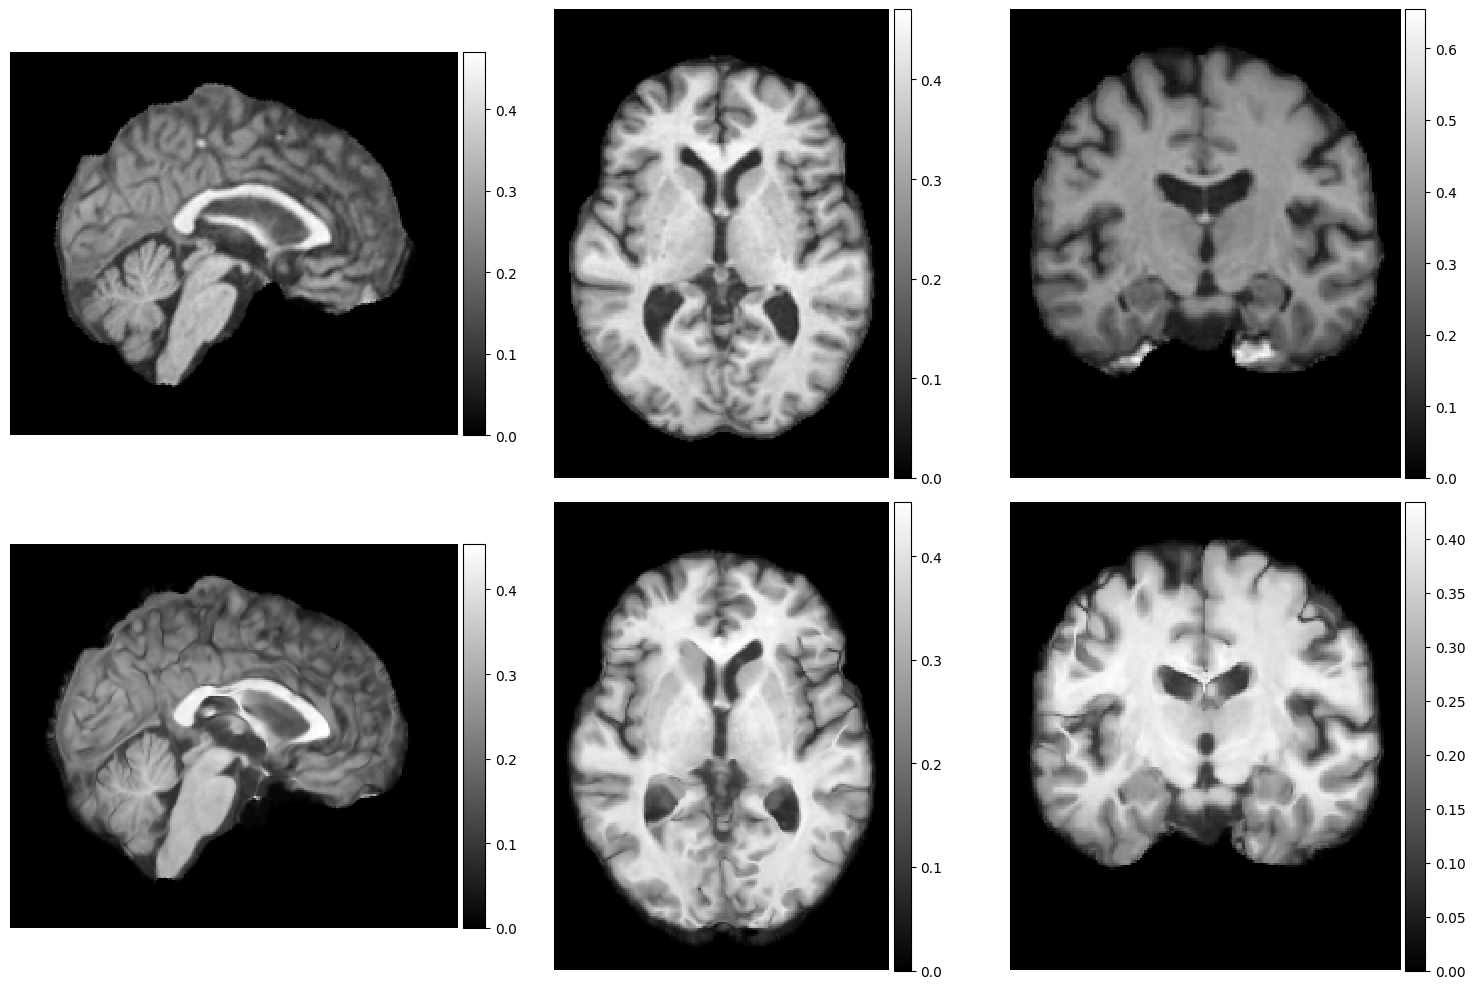

In [62]:
mid_slices_fixed = [np.take(val_volume_2, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_pred = [np.take(moved_pred, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[2,3]);